In [38]:
import os
import datetime
import itertools

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import ConvNeXtTiny
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

print('Modules Loaded')

Modules Loaded


In [39]:
log_dir = r"D:\GLAZE-evaluation\log\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [40]:
data_path = r"D:\GLAZE-evaluation\dataset\train"

images = []
labels = []

for subfolder in os.listdir(data_path):
    subfolder_path = os.path.join(data_path, subfolder)
    if not os.path.isdir(subfolder_path):
        continue

    for image_filename in os.listdir(subfolder_path):
        full_image_path = os.path.join(subfolder_path, image_filename)
        images.append(full_image_path)
        labels.append(subfolder)
        
data = pd.DataFrame({'image': images, 'label': labels})

In [41]:
train_df, valid_test_df = train_test_split(
    data, 
    test_size=0.2, # 20% for validation/test
    stratify=data['label'], 
    random_state=123
)

valid_df, test_df = train_test_split(
    valid_test_df, 
    test_size=0.5, # Split the 20% into two 10% halves
    stratify=valid_test_df['label'], 
    random_state=123
)

train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print(f"Total images found: {len(data)}")
print(f"Train DF size: {len(train_df)}")
print(f"Validation DF size: {len(valid_df)}")
print(f"Test DF size: {len(test_df)}")

Total images found: 400
Train DF size: 320
Validation DF size: 40
Test DF size: 40


In [42]:
data.shape

(400, 2)

In [43]:
img_size = (299, 299)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
batch_size = 32

# Create a new generator for ConvNeXt (no explicit rescaling needed)
# The ConvNeXt model will handle its own normalization internally
convnext_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# NOTE: Do NOT use 'rescale=1/255.0' here!
# If your images are read as uint8 (0-255), keep rescale=None or 1.0
valid_test_datagen = ImageDataGenerator(rescale=1.0)

train_gen = convnext_datagen.flow_from_dataframe(
    train_df,
    x_col='image',
    y_col='label',
    target_size=img_size,
    color_mode='rgb', 
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
)

valid_gen = valid_test_datagen.flow_from_dataframe(
    valid_df,
    x_col='image',
    y_col='label',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

test_gen = valid_test_datagen.flow_from_dataframe(
    test_df,
    x_col='image',
    y_col='label',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

Found 320 validated image filenames belonging to 2 classes.
Found 40 validated image filenames belonging to 2 classes.
Found 40 validated image filenames belonging to 2 classes.


In [44]:
print(len(train_df))
print(len(valid_df))
print(len(test_df))

320
40
40


In [45]:
# Load ConvNeXtTiny with pre-trained weights (weights='imagenet')
base_model = ConvNeXtTiny(
    include_top=False,           # We add our own classification head
    weights='imagenet',          # Use pre-trained weights
    input_shape=img_shape,
    pooling='avg'                # Use Global Average Pooling (as per your existing code logic)
)

In [46]:
# Assuming 'base_model' has already been initialized as shown above

# 1. Get the output tensor of the InceptionV3 model
output_tensor = base_model.output

# 2. Print the shape attribute of the tensor
print(f"The shape of the last InceptionV3 layer is: {output_tensor.shape}")

The shape of the last InceptionV3 layer is: (None, 768)


In [47]:
for layer in base_model.layers:
    layer.trainable = False

In [48]:
x = base_model.output
# You used GlobalAveragePooling2D in your notebook, but the base_model pooling=avg 
# already provides the 2D output, so we can skip a separate pooling layer here, 
# or keep it explicit if you prefer. Let's keep it explicit for clarity.

# Since pooling='avg' is set on the base model, x is already a 2D tensor.
# We skip GlobalAveragePooling2D here because it's already applied by the base_model argument.
# We then directly add the Dense/Dropout layers as in your original script.

x = tf.keras.layers.Dense(256, activation='relu')(x) # Example Dense layer
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(2, activation='softmax')(x) # Final output layer

In [49]:
convnext_model = tf.keras.models.Model(inputs=base_model.input, outputs=output)

In [50]:
convnext_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # Use a low LR for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [51]:
# Assuming 'base_model' has already been initialized as shown above

# 1. Get the output tensor of the InceptionV3 model
output_tensor = base_model.output

# 2. Print the shape attribute of the tensor
print(f"The shape of the last InceptionV3 layer is: {output_tensor.shape}")

The shape of the last InceptionV3 layer is: (None, 768)


In [52]:
checkpoint = ModelCheckpoint(
    'roko_style.h5', 
    monitor='val_accuracy', 
    save_best_only=True, 
    mode='max', 
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.00001,
)

In [53]:
history = convnext_model.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // batch_size,
    validation_data=valid_gen,
    validation_steps=valid_gen.samples // batch_size,
    epochs=5,
    callbacks=[checkpoint, early_stopping, reduce_lr, tensorboard_callback]
)

Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.4827 - loss: 1.1434
Epoch 1: val_accuracy improved from None to 0.40625, saving model to roko_style.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 118s 11s/step - accuracy: 0.5219 - loss: 1.0712 - val_accuracy: 0.4062 - val_loss: 0.8863 - learning_rate: 1.0000e-04
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.5528 - loss: 0.9479 
Epoch 2: val_accuracy improved from 0.40625 to 0.59375, saving model to roko_style.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 115s 12s/step - accuracy: 0.5719 - loss: 0.9074 - val_accuracy: 0.5938 - val_loss: 0.7336 - learning_rate: 1.0000e-04
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.5953 - loss: 0.8993
Epoch 3: val_accuracy improved from 0.59375 to 0.65625, saving model to roko_style.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 110s 11s/step - accuracy: 0.6094 - loss: 0.8151 - val_accuracy: 0.6562 - val_loss: 0.6331 - learning_rate: 1.0000e-04
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.6533 - loss: 0.7509 
Epoch 4: val_accuracy improved from 0.65625 to 0.68750, saving model to roko_style.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 117s 12s/step - accuracy: 0.6656 - loss: 0.6965 - val_accuracy: 0.6875 - val_loss: 0.5614 - learning_rate: 1.0000e-04
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.7401 - loss: 0.5532 
Epoch 5: val_accuracy improved from 0.68750 to 0.71875, saving model to roko_style.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 115s 12s/step - accuracy: 0.7406 - loss: 0.5502 - val_accuracy: 0.7188 - val_loss: 0.5100 - learning_rate: 1.0000e-04


In [55]:
convnext_model.load_weights('roko_style.h5')
convnext_model.save('roko_style_predictor.h5')

In [57]:
test_loss, test_acc = convnext_model.evaluate(test_gen)
print(f'Test Accuracy: {test_acc:.4f}')
print(f'Test Loss: {test_loss:.4f}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.7750 - loss: 0.4502
Test Accuracy: 0.7750
Test Loss: 0.4502


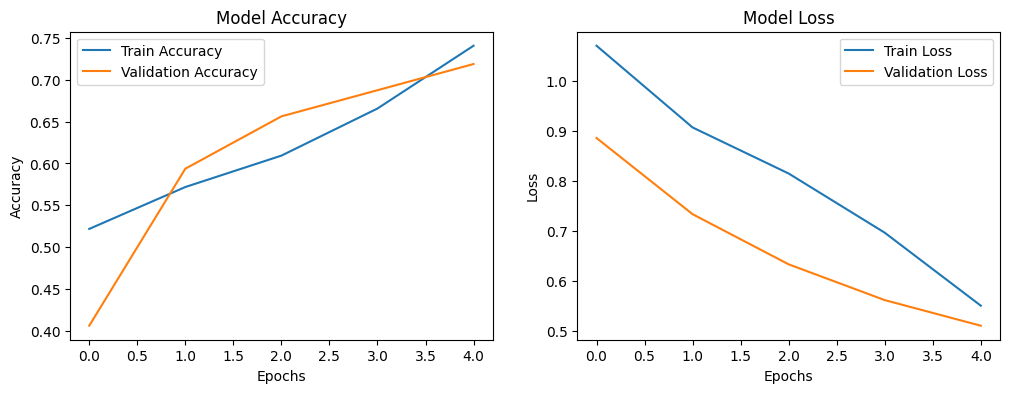

In [58]:
plt.figure(figsize=(12,4))
    
    # Subplot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Subplot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [62]:
test_gen.reset()
y_pred = convnext_model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes

2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step


In [63]:
class_labels = list(test_gen.class_indices.keys())
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

              precision    recall  f1-score   support

512-lora-ori       0.74      0.85      0.79        20
     512-ori       0.82      0.70      0.76        20

    accuracy                           0.78        40
   macro avg       0.78      0.77      0.77        40
weighted avg       0.78      0.78      0.77        40



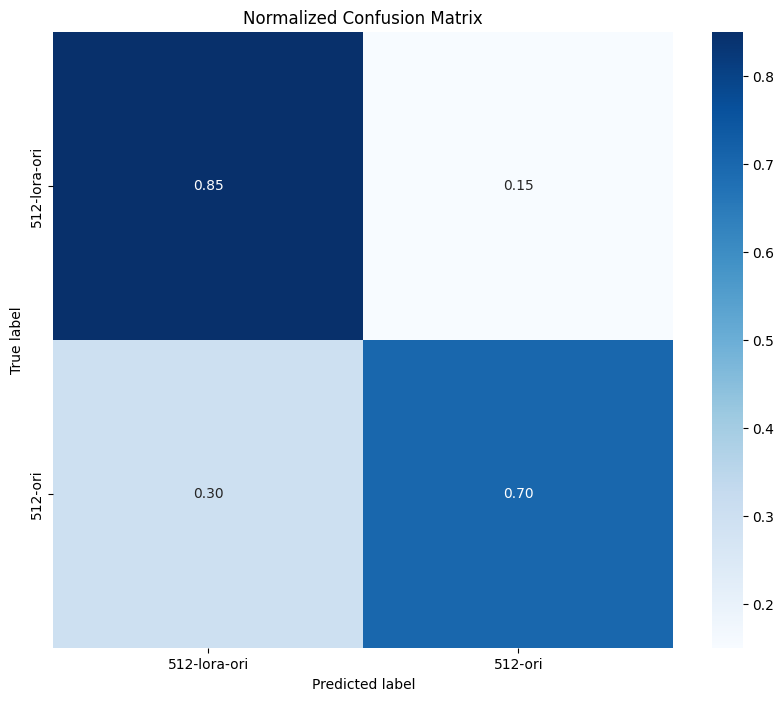

In [64]:
cm = confusion_matrix(y_true, y_pred_classes, normalize='true')

plt.figure(figsize=(10, 8))
sns.heatmap(cm, 
            annot=True, 
            fmt='.2f', 
            cmap='Blues', 
            xticklabels=class_labels, 
            yticklabels=class_labels)

plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()